# Figure of station profile model evaluation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
import netCDF4 as nc
import cmocean
import pandas as pd 
from matplotlib.patches import ConnectionPatch
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
import pickle
from datetime import date

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '/ocean/brogalla/GEOTRACES/analysis-brogalla/modules')
import ariane as ar
import seaborn as sns

###### Parameters:

In [3]:
# domain dimensions:
imin, imax = 1480, 2180
jmin, jmax = 160, 800

# results to plot:
year    = 2009
month   = 8

folder_ref      = f'/data/brogalla/run_storage/Mn-reference-202103/ref-{year}-202103/'
folder_cleanice = f'/data/brogalla/run_storage/Mn-clean-ice-202103/ref-{year}-clean-ice-202103/'
folder_spm      = f'/data/brogalla/run_storage/Mn-spm-202103/ref-{year}-spm-202103/'

# colours:
c_continent    = '#ce9169'
c_glacier      = '#36ab92'
c_other        = '#a6a6a6'
land_color     = "#8b7765"
profile_colors = ['#e54141', '#33c7ff']

##### Load files:

Model results

In [4]:
file = f'ANHA12_EXH006_{year}_monthly.nc'

Mn_model_ref = nc.Dataset(folder_ref+file)

lon_model    = np.array(Mn_model_ref.variables['nav_lon'])
lat_model    = np.array(Mn_model_ref.variables['nav_lat'])
depths_model = np.array(Mn_model_ref.variables['deptht'])
mn_dis_ref   = np.array(Mn_model_ref.variables['dissolmn'])

Meshes

In [5]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
mesh_lon   = np.array(mesh.variables['nav_lon'])
mesh_lat   = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])

In [6]:
mask     = nc.Dataset('/data/brogalla/old/meshmasks/ANHA12_mesh_zgr10.nc')
tmask    = mask.variables['tmask']
tmask    = np.array(tmask[0,:,:,:])
mlons    = np.array(mask.variables['nav_lon'])
mlats    = np.array(mask.variables['nav_lat'])
Z_masked = np.ma.masked_where((tmask > 0.1), tmask) 

Observations

In [7]:
# Concentration of dMn in the Beaufort Sea in 2009.
### Thesis doesn't have a list of lats and lons of station locations --- Jeffrey Charter's thesis does (2012)
IPY = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Nari_Sim_dMn_data.csv')
IPY_names_full = IPY['Station name'].astype('string').values
IPY_depths     = IPY['Depth [m]'].astype('float').values
IPY_dMn        = IPY['DMn [ nmol/kg]'].astype('float').values
IPY_lons_full  = -1*IPY['Longitude'].astype('float').values
IPY_lats_full  = IPY['Latitude'].astype('float').values

# Unique entries (maintaining order)
IPY_lons  = list(dict.fromkeys(IPY_lons_full))
IPY_lats  = list(dict.fromkeys(IPY_lats_full))
IPY_names = list(dict.fromkeys(IPY_names_full))

In [8]:
# Concentration of dMn in 2015
Manuel = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Fe&Mn_Integrated_Data_UBC-UVic_4-17-19_editedBR.csv')
Manuel_station_names = Manuel['Station name'].astype('string')
Manuel_depths        = Manuel['depth'].astype('float').values
Manuel_dMn           = Manuel['avg dMn'].astype('float').values
Manuel_std_dMn       = Manuel['std dMn'].astype('float').values

In [9]:
GEOTRACES = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')
stn_names = GEOTRACES['Station names'].dropna().astype('str')
lons      = GEOTRACES['station lon'].astype('float').dropna().values
lats      = GEOTRACES['Station lat'].astype('float').dropna().values

##### Define functions

In [10]:
def find_index_ANHA12_sub(transect_lons, transect_lats, ANHA12sub_lon=lon_model, ANHA12sub_lat=lat_model):
    # input:   ANHA12sub_lon, ANHA12sub_lat --- 570x600 coordinates
    #          transect_lons, transect_lats --- list of lat and lon values to include in the transect
    # output:  i, j                         --- lists of coordinates associated with these points
    
    transect_i = np.array([])
    transect_j = np.array([])
    
    if isinstance(transect_lons,float):
        i, j = ar.find_closest_model_point(transect_lons, transect_lats, ANHA12sub_lon, ANHA12sub_lat)
        transect_i = i
        transect_j = j
    else:
        for k in range(0,len(transect_lons)):
            i, j = ar.find_closest_model_point(transect_lons[k], transect_lats[k], ANHA12sub_lon, ANHA12sub_lat)
            transect_i = np.append(transect_i, i)
            transect_j = np.append(transect_j, j)
    
    return transect_i, transect_j

In [11]:
def station_profile(ax, name, month, manuel=False, patch=False):
    
    ax.invert_yaxis()
    ax.tick_params(labelsize=6, pad=0)
    
    # observations: -------------------------------------------------------------------------------------------
    if manuel:
        dMn_obs   = Manuel_dMn[np.array(Manuel_station_names==name).astype('bool')]
        depth_obs = Manuel_depths[np.array(Manuel_station_names==name).astype('bool')]
    else:
        dMn_obs   = IPY_dMn[np.array(IPY_names_full==name).astype('bool')]
        depth_obs = IPY_depths[np.array(IPY_names_full==name).astype('bool')]
    
    ax.plot(dMn_obs, depth_obs, '.-', \
            zorder=4, markeredgewidth=0.5, markeredgecolor='k', color=profile_colors[0], markersize=7, linewidth=1.8)
    
    plot_depth_lowerrange = depth_obs[-1] #deepest observation    
    plot_depth_upperrange = depth_obs[0] # shallowest observation

    # model: --------------------------------------------------------------------------------------------------
    if manuel:
        lon_station = lons[stn_names==name]
        lat_station = lats[stn_names==name]
    else:
        lon_station = IPY_lons[IPY_names==name]
        lat_station = IPY_lats[IPY_names==name]
    
    model_stni, model_stnj = find_index_ANHA12_sub(lon_station, lat_station)
    model_stni = int(model_stni); model_stnj = int(model_stnj);

    mn_ref = mn_dis_ref[month, 0, :, model_stni, model_stnj]*10**9
    mn_ref_masked = np.ma.masked_where((tmask[:,model_stni+imin, model_stnj+jmin] < 0.1), mn_ref)
    
    # Run with sediment in sea ice:
    ax.plot(mn_ref_masked[depths_model > plot_depth_upperrange], \
            depths_model[depths_model > plot_depth_upperrange], '.-', \
            zorder=1, linewidth=1.8, color=profile_colors[1], markeredgecolor='k', markeredgewidth=0.5, markersize=7)
        
    ax.set_ylim([plot_depth_lowerrange*1.2, 0-(plot_depth_lowerrange*0.04)])
    ax.set_xlim([-2, 15])
    ax.xaxis.tick_top()    
    ax.xaxis.set_label_position('top') 
    ax.set_xticks([0,5,10,15])
    ax.text(5.5, plot_depth_lowerrange*0.98, name, fontsize=6)
    
    if patch:
        # Background patches behind profiles: ----------------------------------------------------------------------
        #top patch:
        x0_top     = -11
        y0_top     = -(plot_depth_lowerrange*0.3)
        width_top  = 15+12.4
        height_top = (plot_depth_lowerrange*0.3)
        box_top    = mpl.patches.Rectangle((x0_top,y0_top), width_top, height_top, facecolor='w', clip_on=False, \
                                          alpha=0.9, zorder=1)
        ax.add_patch(box_top)

        #left side patch:
        x0_side     = -11
        y0_side     = 0#-(plot_depth_lowerrange*0.04)
        width_side  = 15+12.4
        height_side = plot_depth_lowerrange*1.24
        box_side    = mpl.patches.Rectangle((x0_side,y0_side), width_side, height_side, \
                                            facecolor='w', clip_on=False, alpha=0.9, zorder=1)
        ax.add_patch(box_side)
    
    return

#### Figure:

In [19]:
# Connect these points with straight line segments:
transect_lons = [lons[stn_names=='CB4'], lons[stn_names=='CB3'],lons[stn_names=='CB2'], lons[stn_names=='CB1'], \
                 lons[stn_names=='CAA8'], lons[stn_names=='CAA6'], lons[stn_names=='CAA7'], lons[stn_names=='CAA4'],\
                 lons[stn_names=='CAA5'], lons[stn_names=='CAA1'], lons[stn_names=='CAA2'], lons[stn_names=='CAA3']]
transect_lats = [lats[stn_names=='CB4'], lats[stn_names=='CB3'],lats[stn_names=='CB2'], lats[stn_names=='CB1'], \
                 lats[stn_names=='CAA8'], lats[stn_names=='CAA6'], lats[stn_names=='CAA7'], lats[stn_names=='CAA4'],\
                 lats[stn_names=='CAA5'], lats[stn_names=='CAA1'], lats[stn_names=='CAA2'], lats[stn_names=='CAA3']]
transect_names = ['CB4','CB3', 'CB2', 'CB1', 'CAA8', 'CAA6', 'CAA7', 'CAA4', 'CAA5', 'CAA1', 'CAA2', 'CAA3']

In [20]:
# Create vectors of many points along these segments:
transect_vlons = np.array([])
transect_vlats = np.array([])
for i in range(0,len(transect_lons)-1):
    diff_lons = transect_lons[i+1] - transect_lons[i]
    diff_lats = transect_lats[i+1] - transect_lats[i]
    vector_lons = transect_lons[i] + np.linspace(0,diff_lons,30)
    vector_lats = transect_lats[i] + np.linspace(0,diff_lats,30)
    transect_vlons = np.append(transect_vlons, vector_lons)
    transect_vlats = np.append(transect_vlats, vector_lats)

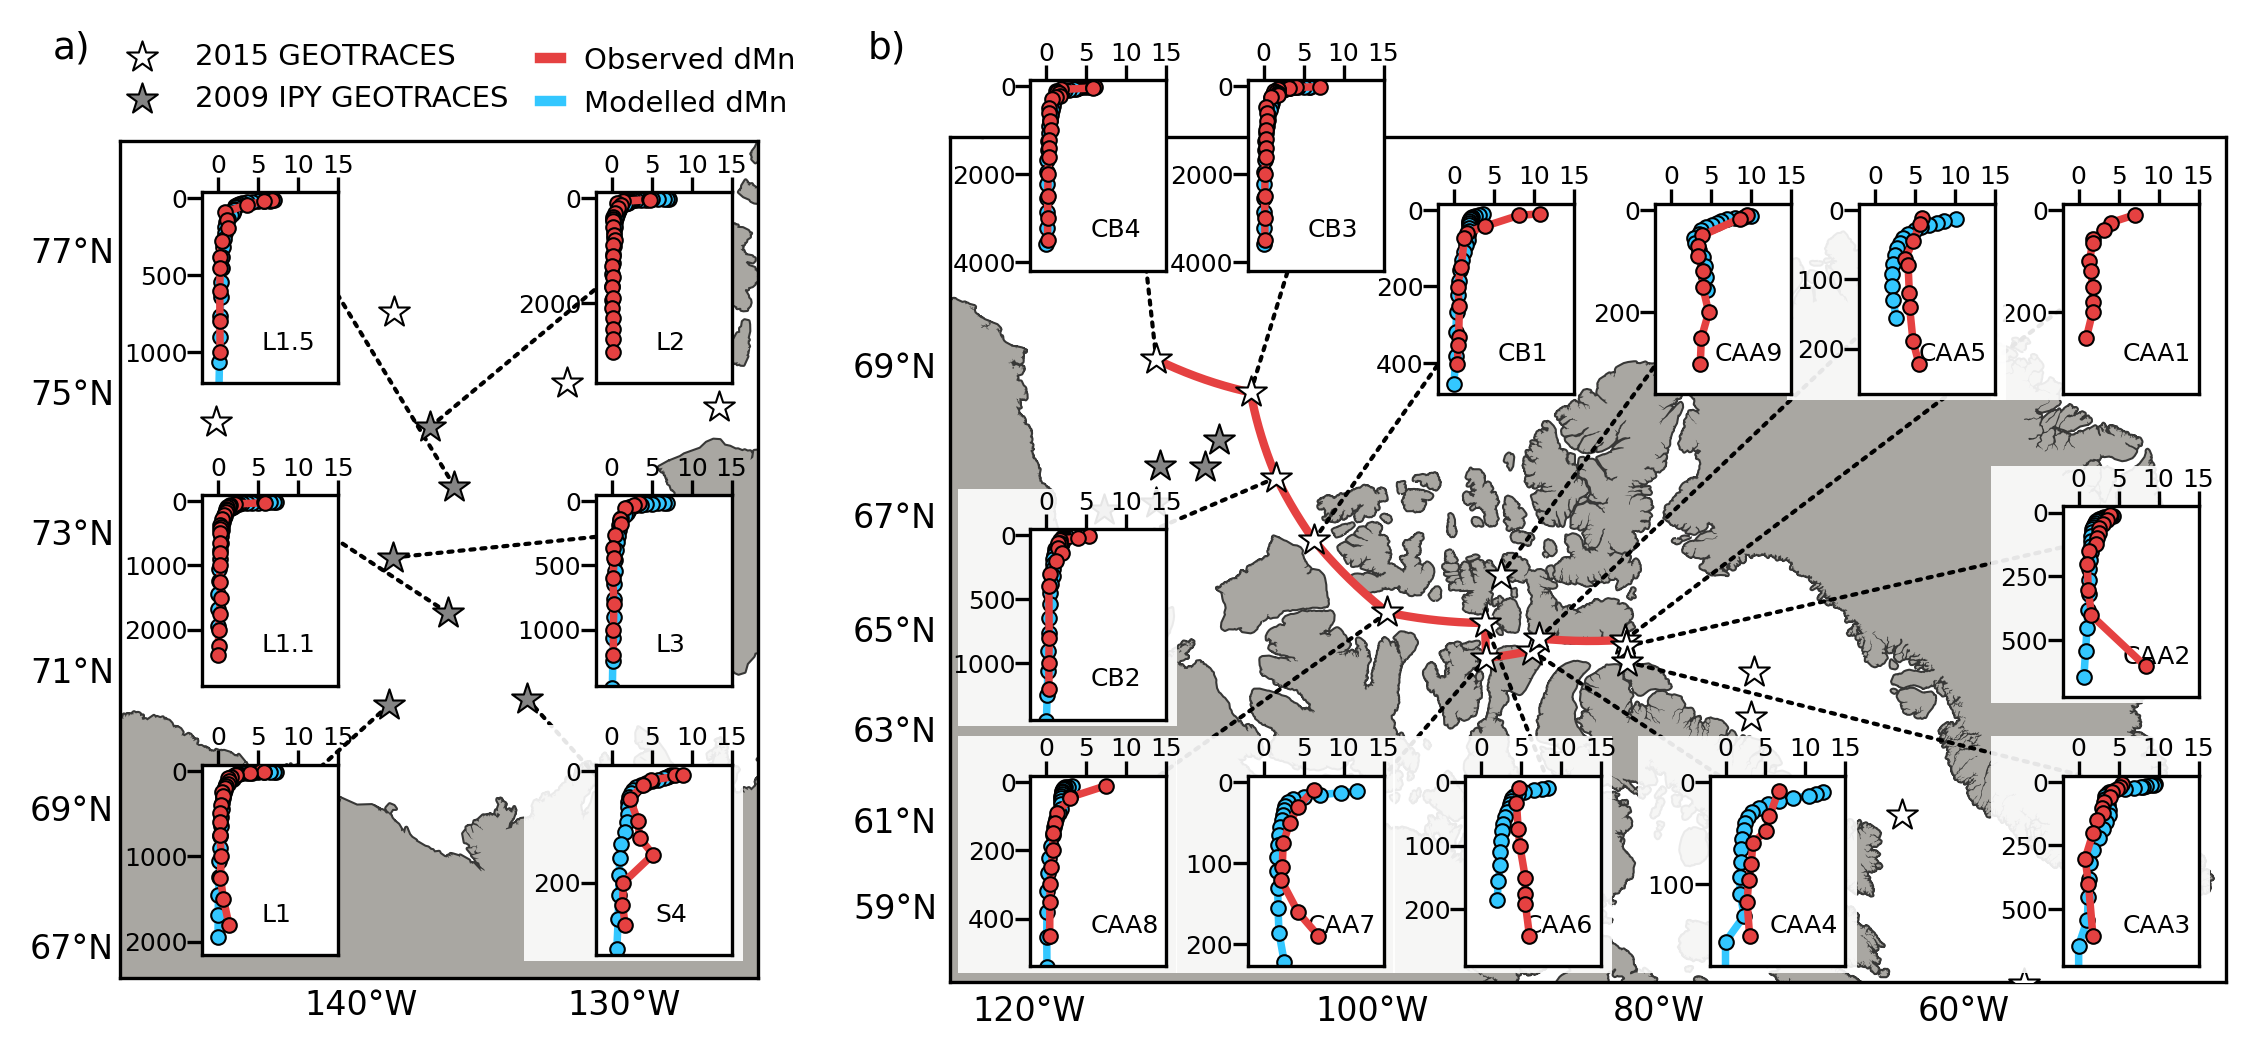

In [24]:
fig, ax, proj1, proj2 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/mn-eval-combined.pickle','rb'))

#--------------------------------------------------------------------------------------------------------------------------
### Left plot ###

# # profile plots:
ax1 = plt.axes([0.155, 0.15, 0.05, 0.17]) #L1
ax2 = plt.axes([0.155, 0.39, 0.05, 0.17]) #L1.1 
ax3 = plt.axes([0.155, 0.66, 0.05, 0.17]) #L1.5 
ax4 = plt.axes([0.3, 0.66, 0.05, 0.17])  #L2
ax5 = plt.axes([0.3, 0.39, 0.05, 0.17]) #L3
ax6 = plt.axes([0.3, 0.15, 0.05, 0.17])  #S4
axes_list = [ax1, ax2, ax3, ax4, ax5, ax6]
    
fig1 = station_profile(ax1, 'L1'  , month)
fig2 = station_profile(ax2, 'L1.1', month)
fig3 = station_profile(ax3, 'L1.5', month)
fig4 = station_profile(ax4, 'L2'  , month)
fig5 = station_profile(ax5, 'L3'  , month)
fig6 = station_profile(ax6, 'S4'  , month, patch=True)

x_GEOTRACES, y_GEOTRACES = proj1(lons, lats)
x_IPY      , y_IPY       = proj1(IPY_lons, IPY_lats)
ax[0].scatter(x_GEOTRACES, y_GEOTRACES, marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='w', label='2015 GEOTRACES')
ax[0].scatter(x_IPY      , y_IPY      , marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='#848484', label='2009 IPY GEOTRACES')
ax[0].legend(loc=(-0.03, 1.02), fontsize=7, frameon=False)

# create lines connecting the profiles:
coordsA = "data"
coordsB = "data"
for i in range(len(IPY_names)):
    xy1 = (x_IPY[i], y_IPY[i])
    xy2 = (10, 200)
    axB = axes_list[i]
    con = ConnectionPatch(xyA=xy1, xyB=xy2, axesA=ax[0], axesB=axB, \
                          coordsA=coordsA, coordsB=coordsB, linestyle="dotted", linewidth=1.0, zorder=3)
    ax[0].add_artist(con)
    
# ax[0].text(1.1e5, 0.75e6, 'Dissolved Mn [nM]', fontsize=8)
# ax[0].text(0.1e5, 0.50e6, 'Depth [m]', fontsize=8, rotation=90)

#--------------------------------------------------------------------------------------------------------------------------
### Right plot ###

x_GEOTRACES, y_GEOTRACES = proj2(lons, lats)
x_IPY      , y_IPY       = proj2(IPY_lons, IPY_lats)
ax[1].scatter(x_GEOTRACES, y_GEOTRACES, marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='w')
ax[1].scatter(x_IPY      , y_IPY      , marker='*', s=60, zorder=7, edgecolor='k', linewidth=0.5, color='#848484')

# profile plots:
ax1 = plt.axes([0.84, 0.65, 0.05, 0.17])
ax2 = plt.axes([0.84, 0.38, 0.05, 0.17]) #CAA1
ax3 = plt.axes([0.84, 0.14, 0.05, 0.17]) 
ax4 = plt.axes([0.71, 0.14, 0.05, 0.17])
ax5 = plt.axes([0.765, 0.65, 0.05, 0.17])
ax6 = plt.axes([0.62, 0.14, 0.05, 0.17]) 
ax7 = plt.axes([0.54, 0.14, 0.05, 0.17])
ax8 = plt.axes([0.46, 0.14, 0.05, 0.17])
ax9 = plt.axes([0.69, 0.65, 0.05, 0.17])
ax10 = plt.axes([0.61, 0.65, 0.05, 0.17]) #CB1
ax11 = plt.axes([0.46, 0.36, 0.05, 0.17])
ax12 = plt.axes([0.54, 0.76, 0.05, 0.17])
ax13 = plt.axes([0.46, 0.76, 0.05, 0.17])

axes_list=[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13]

fig1 = station_profile(ax1, 'CAA1', month, manuel=True, patch=True)
fig2 = station_profile(ax2, 'CAA2', month, manuel=True, patch=True)
fig3 = station_profile(ax3, 'CAA3', month, manuel=True, patch=True)
fig4 = station_profile(ax4, 'CAA4', month, manuel=True, patch=True)
fig5 = station_profile(ax5, 'CAA5', month, manuel=True, patch=True)
fig6 = station_profile(ax6, 'CAA6', month, manuel=True, patch=True)
fig7 = station_profile(ax7, 'CAA7', month, manuel=True, patch=True)
fig8 = station_profile(ax8, 'CAA8', month, manuel=True, patch=True)
fig9 = station_profile(ax9, 'CAA9', month, manuel=True)
fig10 = station_profile(ax10, 'CB1', month, manuel=True)
fig11 = station_profile(ax11, 'CB2', month, manuel=True, patch=True)
fig12 = station_profile(ax12, 'CB3', month, manuel=True)
fig13 = station_profile(ax13, 'CB4', month, manuel=True)

# create lines connecting the profiles:
coordsA = "data"
coordsB = "data"
for i in range(len(stn_names[5:18])):
    xy1 = (x_GEOTRACES[i+5], y_GEOTRACES[i+5])
    xy2 = (10, 50)#300/2)
    axB = axes_list[i]
    con = ConnectionPatch(xyA=xy1, xyB=xy2, axesA=ax[1], axesB=axB, \
                          coordsA=coordsA, coordsB=coordsB, linestyle="dotted", linewidth=1.0, zorder=2)
    ax[1].add_artist(con)
    
# Transect: 
xt, yt = proj2(transect_vlons, transect_vlats)
proj2.plot(xt, yt, c=profile_colors[0], linewidth=2, zorder=2)  
    
# legend
ax[1].plot(0,0,'-', c=profile_colors[0], linewidth=2.5, label='Observed dMn')
ax[1].plot(0,0,'-', c=profile_colors[1], linewidth=2.5, label='Modelled dMn')
ax[1].legend(loc=(-0.33, 1.01), fontsize=7, frameon=False, handlelength=0.7)

#-----------------------------------------------------------------------------------------------------------------------------------
### Full figure ###
fig.text(0.1, 0.95, 'a)', fontsize=9);
fig.text(0.4, 0.95, 'b)', fontsize=9);

# figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202104/R1-profile_evaluation-ref.png', \
#                bbox_inches='tight', dpi=300)
# figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202104/R1-profile_evaluation-ref.svg', \
#                bbox_inches='tight', dpi=300, format='svg')

Load additional data:

In [13]:
file_ref_2009      = nc.Dataset(f'/data/brogalla/run_storage/Mn-reference-202103/ref-2009-202103/ANHA12_EXH006_2009_monthly.nc')
file_cleanice_2009 = nc.Dataset(f'/data/brogalla/run_storage/Mn-clean-ice-202103/ref-2009-clean-ice-202103/ANHA12_EXH006_2009_monthly.nc')
file_spm_2009      = nc.Dataset(f'/data/brogalla/run_storage/Mn-spm-202103/ref-2009-spm-202103/ANHA12_EXH006_2009_monthly.nc')
mn_ref_2009      = np.array(file_ref_2009.variables['dissolmn'])
mn_cleanice_2009 = np.array(file_cleanice_2009.variables['dissolmn'])
mn_spm_2009      = np.array(file_spm_2009.variables['dissolmn'])

file_ref_2015      = nc.Dataset(f'/data/brogalla/run_storage/Mn-reference-202103/ref-2015-202103/ANHA12_EXH006_2015_monthly.nc')
file_cleanice_2015 = nc.Dataset(f'/data/brogalla/run_storage/Mn-clean-ice-202103/ref-2015-clean-ice-202103/ANHA12_EXH006_2015_monthly.nc')
file_spm_2015      = nc.Dataset(f'/data/brogalla/run_storage/Mn-spm-202103/ref-2015-spm-202103/ANHA12_EXH006_2015_monthly.nc')
mn_ref_2015      = np.array(file_ref_2015.variables['dissolmn'])
mn_cleanice_2015 = np.array(file_cleanice_2015.variables['dissolmn'])
mn_spm_2015      = np.array(file_spm_2015.variables['dissolmn'])

In [14]:
def calc_scatter(name):    
    try:
        a = not(Manuel_dMn[np.array(Manuel_station_names==name).astype('bool')]) # returns true if name is not in list of station names
        print(f'data from IPY stn {name}')
        # observations
        dmn_stn   = IPY_dMn[np.array(IPY_names_full==name).astype('bool')]
        depth_stn = IPY_depths[np.array(IPY_names_full==name).astype('bool')]
        lon_station = IPY_lons[IPY_names==name]
        lat_station = IPY_lats[IPY_names==name]    
        # model data:
        model_stni, model_stnj = find_index_ANHA12_sub(lon_station, lat_station)
        model_stni = int(model_stni); model_stnj = int(model_stnj);
        mn_ref      = mn_ref_2009[month,0,:,model_stni,model_stnj]*10**9
        mn_cleanice = mn_cleanice_2009[month,0,:,model_stni,model_stnj]*10**9
        mn_spm      = mn_spm_2009[month,0,:,model_stni,model_stnj]*10**9
    except:
        print(f'data from 2015 stn {name}')
        # observations
        dmn_stn   = Manuel_dMn[np.array(Manuel_station_names==name).astype('bool')]
        depth_stn = Manuel_depths[np.array(Manuel_station_names==name).astype('bool')]
        lon_station = lons[stn_names==name]
        lat_station = lats[stn_names==name]        
        # model data:
        model_stni, model_stnj = find_index_ANHA12_sub(lon_station, lat_station)
        model_stni = int(model_stni); model_stnj = int(model_stnj);
        mn_ref      = mn_ref_2015[month,0,:,model_stni,model_stnj]*10**9
        mn_cleanice = mn_cleanice_2015[month,0, :,model_stni,model_stnj]*10**9
        mn_spm      = mn_spm_2015[month,0,:,model_stni,model_stnj]*10**9

    mn_ref_masked      = np.ma.masked_where((tmask[:,model_stni+imin, model_stnj+jmin] < 0.1), mn_ref)
    mn_cleanice_masked = np.ma.masked_where((tmask[:,model_stni+imin, model_stnj+jmin] < 0.1), mn_cleanice)
    mn_spm_masked      = np.ma.masked_where((tmask[:,model_stni+imin, model_stnj+jmin] < 0.1), mn_spm)
    
    # match data:
    m1 = []; m2 = []; m3 = [];
    for depth_obs in depth_stn[(depth_stn < 50) & (depth_stn > 5)]:
        d1 = np.argmin(np.abs(depths_model-depth_obs))
        m1.append(mn_ref_masked[d1])
        m2.append(mn_cleanice_masked[d1])
        m3.append(mn_spm_masked[d1])
    
    dmn_m1  = m1; dmn_m2  = m2; dmn_m3  = m3
    dmn_obs = list(dmn_stn[(depth_stn < 50) & (depth_stn > 5)])
    
    return dmn_m1, dmn_m2, dmn_m3, dmn_obs

In [15]:
stations_2015 = ['CAA1','CAA2','CAA3','CAA4','CAA5','CAA6','CAA7','CAA8','CAA9','CB1','CB2','CB3','CB4']
stations_2009 = ['L1','L1.1','L1.5','L2']#,'L3','S4'] ##### Check what's going on with the flat lines in the model at certain stations.
all_stations  = stations_2009+stations_2015

dmn_ref_all   = np.empty((len(all_stations),10)); dmn_clean_all = np.empty((len(all_stations),10));
dmn_spm_all   = np.empty((len(all_stations),10)); dmn_obs_all   = np.empty((len(all_stations),10));
dmn_ref_all[:] = np.nan; dmn_clean_all[:] = np.nan; dmn_spm_all[:] = np.nan; dmn_obs_all[:] = np.nan;
for n,stn in enumerate(all_stations):
    dmn_ref, dmn_cleanice, dmn_spm, dmn_ob = calc_scatter(stn)

    dmn_ref_all[n,0:len(dmn_ref)]        = dmn_ref
    dmn_clean_all[n,0:len(dmn_cleanice)] = dmn_cleanice
    dmn_spm_all[n,0:len(dmn_spm)]        = dmn_spm
    dmn_obs_all[n,0:len(dmn_ob)]         = dmn_ob

data from IPY stn L1
data from IPY stn L1.1
data from IPY stn L1.5
data from IPY stn L2
data from 2015 stn CAA1
data from 2015 stn CAA2
data from 2015 stn CAA3
data from 2015 stn CAA4
data from 2015 stn CAA5
data from 2015 stn CAA6
data from 2015 stn CAA7
data from 2015 stn CAA8
data from 2015 stn CAA9
data from 2015 stn CB1
data from 2015 stn CB2
data from 2015 stn CB3
data from 2015 stn CB4


In [16]:
dmn_dirty = dmn_ref_all
dmn_clean = dmn_clean_all
dmn_rivers = dmn_spm_all
dmn_observ = dmn_obs_all

delta_dmn_ice     = np.array(dmn_dirty)  - np.array(dmn_clean)
delta_dmn_rivers  = np.array(dmn_rivers) - np.array(dmn_dirty)
dmn_clean_rivers  = np.array(dmn_rivers) - delta_dmn_ice

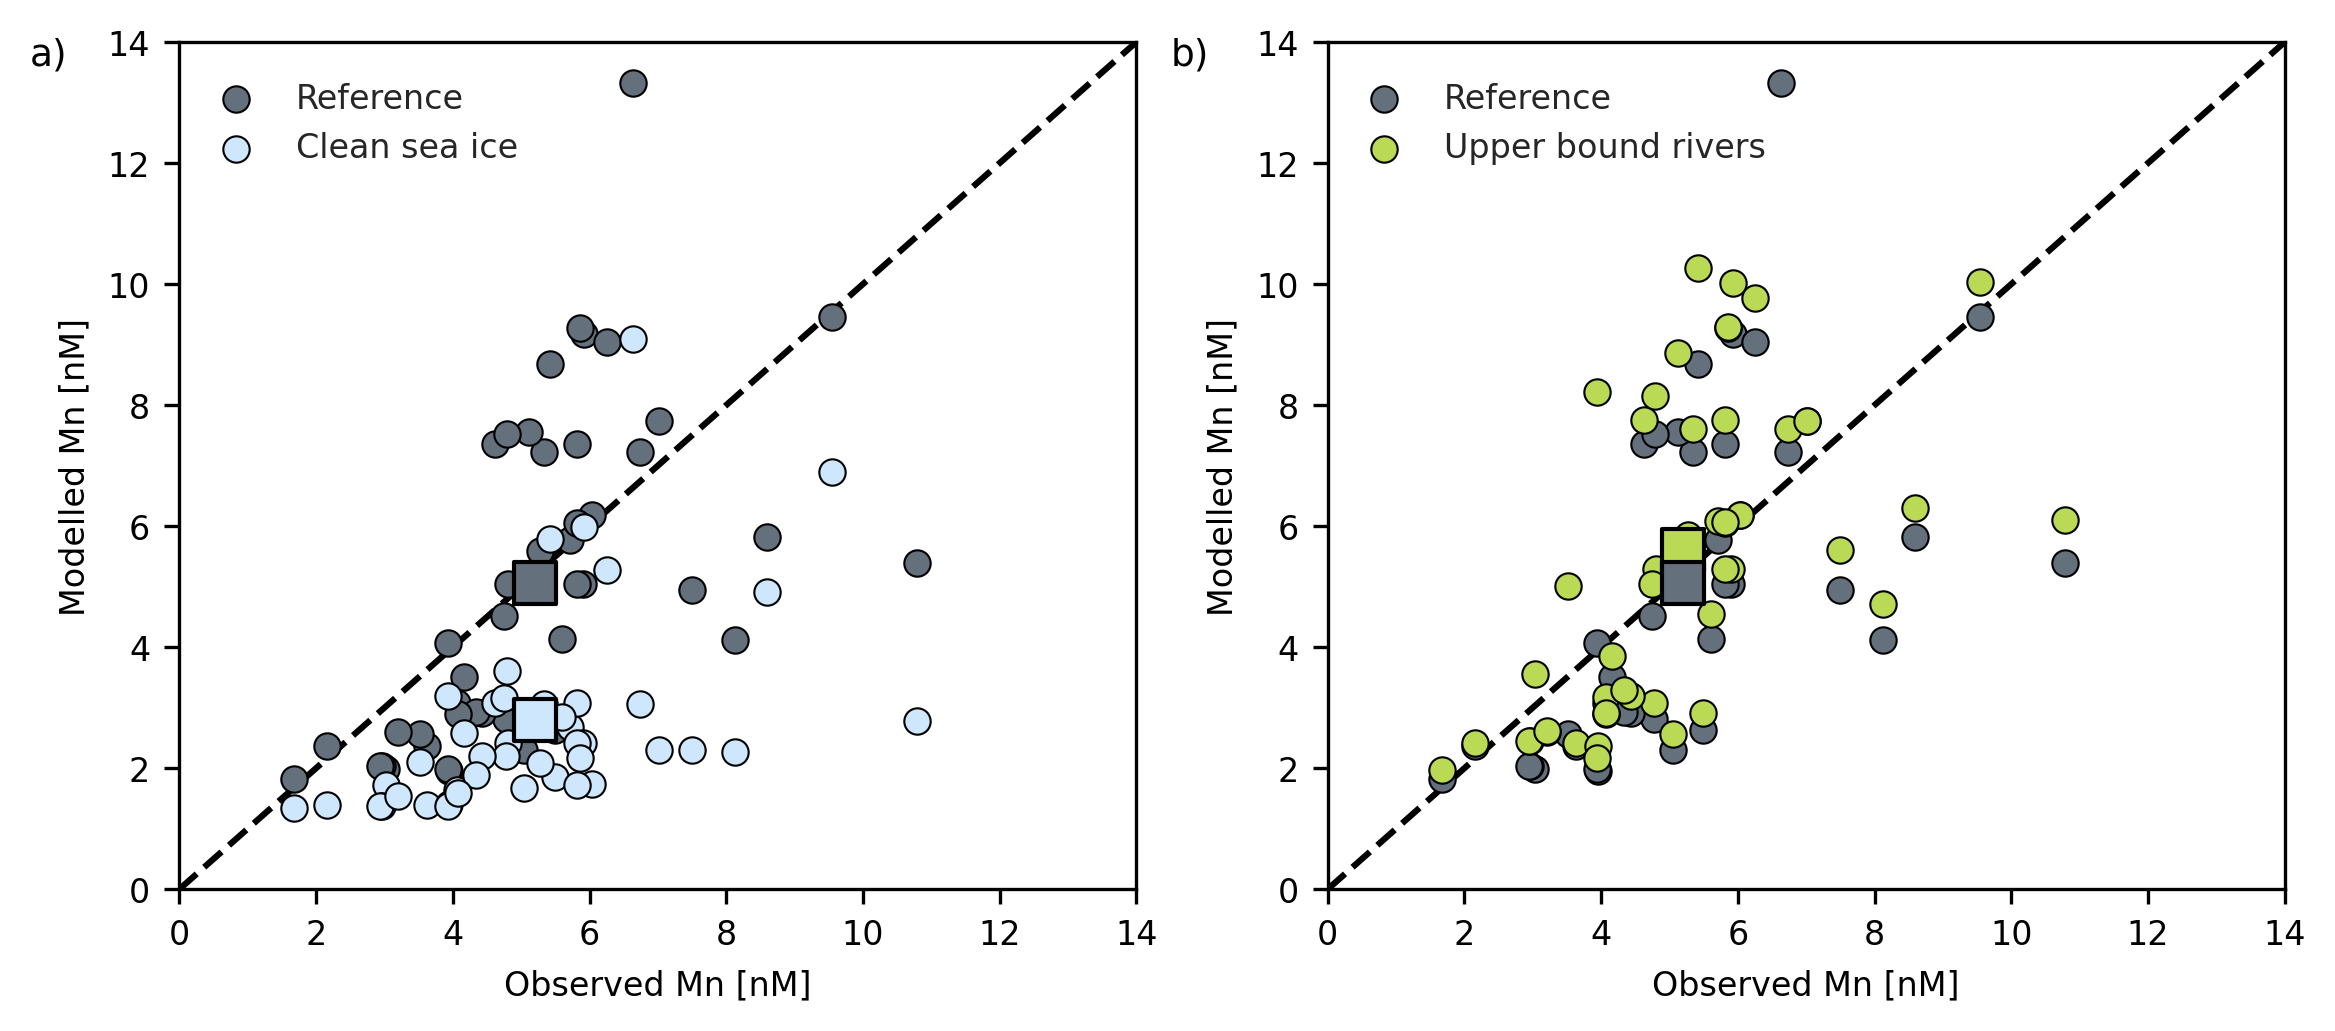

In [18]:
fig, ax = plt.subplots(1,2, figsize=(9.055, 3.74), dpi=300)
st = sns.axes_style("ticks")

# Colors:
rivers = '#bada55'
dirty  = '#64707b'
clean  = '#cee7fd'

with st:   
    for axis in ax:
        line1 = sns.lineplot([0, 20],[0, 20], c='k', linewidth=1.5, zorder=1, ax=axis)
        line1.lines[0].set_linestyle('--')
        axis.set_xlabel('Observed Mn [nM]', fontsize=8)
        axis.set_ylabel('Modelled Mn [nM]',fontsize=8)
        axis.set(xlim=(0, 14.), ylim=(0, 14.))
        axis.tick_params(axis='both', which='major', labelsize=8) 

    ### Left plot ###
    sns.scatterplot(dmn_observ.flatten(), dmn_dirty.flatten() , label=r'Reference', s=40, \
                    edgecolor='k', color=dirty, zorder=2, ax=ax[0])
    sns.scatterplot(dmn_observ.flatten(), dmn_clean.flatten() , label=r'Clean sea ice' , s=40, \
                    edgecolor='k', color=clean, zorder=2, ax=ax[0])
    sns.scatterplot([np.nanmean(dmn_observ)], [np.nanmean(dmn_dirty)], s=100, linewidth=1.0, \
                    edgecolor='k', marker='s', color=dirty, zorder=3, ax=ax[0])
    sns.scatterplot([np.nanmean(dmn_observ)], [np.nanmean(dmn_clean)], s=100, linewidth=1.0, \
                    edgecolor='k', marker='s', color=clean, zorder=3, ax=ax[0])
    ax[0].legend(loc=(0.01, 0.84), frameon=False, fontsize=8)
    
    ### Right plot ###
    sns.scatterplot(dmn_observ.flatten(), dmn_dirty.flatten() , label=r'Reference', s=40, \
                    edgecolor='k', color=dirty, zorder=2, ax=ax[1])
    sns.scatterplot(dmn_observ.flatten(), dmn_rivers.flatten(), label=r'Upper bound rivers', s=40, \
                    edgecolor='k', color=rivers, zorder=2, ax=ax[1])
    sns.scatterplot([np.nanmean(dmn_observ)], [np.nanmean(dmn_rivers)], s=100, linewidth=1.0, \
                    edgecolor='k', marker='s', color=rivers, zorder=3, ax=ax[1])
    sns.scatterplot([np.nanmean(dmn_observ)], [np.nanmean(dmn_dirty)], s=100, linewidth=1.0, \
                    edgecolor='k', marker='s', color=dirty, zorder=3, ax=ax[1])
    ax[1].legend(loc=(0.01, 0.84), frameon=False, fontsize=8)
    
#-----------------------------------------------------------------------------------------------------------------------------------
### Full figure ###
fig.text(0.07, 0.86, 'a)', fontsize=9);
fig.text(0.49, 0.86, 'b)', fontsize=9);

# figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202104/R3-model-vs-observations.png', \
#                bbox_inches='tight', dpi=300, transparent=True)
# figure.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202104/R3-model-vs-observations.svg', \
#                bbox_inches='tight', dpi=300, format='svg')